# Final Project
## CSCE 633
## Arya Rahmanian
## Summer 2024

### Load Dataset

In [182]:
import pandas as pd

# Load data
train_df = pd.read_csv("yelp_review_train.csv")
test_df = pd.read_csv("yelp_review_test.csv")

# Randomly select data points for training, validation, and testing
train_data = train_df.sample(n=10000, random_state=42)
val_data = train_df.drop(train_data.index).sample(n=1000, random_state=42)
test_data = test_df.sample(n=2000, random_state=42)

print(train_data.head())
#print(val_data.head())
print(test_data.head())


                                                     text  stars
117921  This was a tough one.  After having heard good...    3.0
117777  I have been here probably 3 times in the last ...    3.0
172811  I don't usually do chain restaurants, but I st...    4.0
63245   This place is just out there... There main onl...    1.0
87607   Went here for Happy Hour one evening. Twas a g...    4.0
                                                    text  stars
13742  Sadly I tried chipotle again after the last re...    3.0
12304  This place sells really good fresh corn tortil...    4.0
6107   Having only recently moved to PA, I'm still ge...    4.0
2796   This is by far my favorite breakfast spot in N...    5.0
3379   This is a great store. I come here often, ever...    5.0


In [183]:
import numpy as np
"""
def load_glove_embeddings(file_path):
    embedding_dict = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embedding_dict[word] = vector
    return embedding_dict


glove_file = 'glove.twitter.27B.50d.txt'  

embedding_dict = load_glove_embeddings(glove_file)
"""

"\ndef load_glove_embeddings(file_path):\n    embedding_dict = {}\n    with open(file_path, 'r', encoding='utf-8') as f:\n        for line in f:\n            values = line.split()\n            word = values[0]\n            vector = np.array(values[1:], dtype='float32')\n            embedding_dict[word] = vector\n    return embedding_dict\n\n\nglove_file = 'glove.twitter.27B.50d.txt'  \n\nembedding_dict = load_glove_embeddings(glove_file)\n"

### Data Pre-Processing

In [184]:
def map_labels(stars):
    return 0 if stars < 4 else 1

# create our label column
train_data['label'] = train_data['stars'].apply(map_labels)
test_data['label'] = test_data['stars'].apply(map_labels)
val_data['label'] = val_data['stars'].apply(map_labels)


In [185]:
import re
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

#function to preprocess text
def preprocess_text(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply preprocessing to the 'text' column
train_data['text'] = train_data['text'].apply(preprocess_text)
val_data['text'] = val_data['text'].apply(preprocess_text)
test_data['text'] = test_data['text'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to C:\Users\Arya
[nltk_data]     Rahmanian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Tokenize and Pad Text Vectors

In [186]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['text'])

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_data['text'])
val_sequences = tokenizer.texts_to_sequences(val_data['text'])
test_sequences = tokenizer.texts_to_sequences(test_data['text'])

# Define a maximum length for sequences
max_length = 150

# Pad/Truncate sequences to the same length
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

# Display the shape of the padded sequences
print(train_padded.shape)
print(val_padded.shape)
print(test_padded.shape)

(10000, 150)
(1000, 150)
(2000, 150)


### Build Model

#### Transformer

In [187]:
"""
class TransformerSentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, hidden_dim, num_layers, num_classes, max_length):
        super(TransformerSentimentClassifier, self).__init__()
        
        # embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        # positional encoding
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_length, embed_dim))
        
        # transformer encoder layers
        encoder_layers = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        
        self.fc = nn.Linear(embed_dim, num_classes)
        
    def forward(self, x):
       
        x = self.embedding(x)  # (batch_size, max_length, embed_dim)
        x += self.positional_encoding[:, :x.size(1), :]
        
        x = x.permute(1, 0, 2) 
        x = self.transformer_encoder(x)  # (max_length, batch_size, embed_dim)
        
        x = x.mean(dim=0)  # (batch_size, embed_dim)
        x = self.fc(x)  # (batch_size, num_classes)
        return x
"""

'\nclass TransformerSentimentClassifier(nn.Module):\n    def __init__(self, vocab_size, embed_dim, num_heads, hidden_dim, num_layers, num_classes, max_length):\n        super(TransformerSentimentClassifier, self).__init__()\n        \n        # embedding layer\n        self.embedding = nn.Embedding(vocab_size, embed_dim)\n        \n        # positional encoding\n        self.positional_encoding = nn.Parameter(torch.zeros(1, max_length, embed_dim))\n        \n        # transformer encoder layers\n        encoder_layers = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim)\n        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)\n        \n        self.fc = nn.Linear(embed_dim, num_classes)\n        \n    def forward(self, x):\n       \n        x = self.embedding(x)  # (batch_size, max_length, embed_dim)\n        x += self.positional_encoding[:, :x.size(1), :]\n        \n        x = x.permute(1, 0, 2) \n      

In [188]:
"""
# Parameters
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
embed_dim = 128
num_heads = 4
hidden_dim = 256
num_layers = 2
num_classes = 2  

# Initialize model
model = TransformerSentimentClassifier(vocab_size, embed_dim, num_heads, hidden_dim, num_layers, num_classes, max_length)

# Print the model architecture
print(model)
"""

'\n# Parameters\nvocab_size = len(tokenizer.word_index) + 1  # +1 for padding token\nembed_dim = 128\nnum_heads = 4\nhidden_dim = 256\nnum_layers = 2\nnum_classes = 2  \n\n# Initialize model\nmodel = TransformerSentimentClassifier(vocab_size, embed_dim, num_heads, hidden_dim, num_layers, num_classes, max_length)\n\n# Print the model architecture\nprint(model)\n'

In [189]:
class TransformerSentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, hidden_dim, num_layers, num_classes, max_length, dropout=0.1):
        super(TransformerSentimentClassifier, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = self.create_positional_encoding(max_length, embed_dim)
        
        encoder_layers = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(embed_dim)
        
    def create_positional_encoding(self, max_length, embed_dim):
        pe = torch.zeros(max_length, embed_dim)
        position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-np.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_length, embed_dim)
        return nn.Parameter(pe, requires_grad=False)
    
    def forward(self, x, mask=None):
        x = self.embedding(x)  # (batch_size, max_length, embed_dim)
        x = x + self.positional_encoding[:, :x.size(1), :]
        x = self.layer_norm(x)
        
        x = x.permute(1, 0, 2)  # (max_length, batch_size, embed_dim)
        x = self.transformer_encoder(x, src_key_padding_mask=mask)  # (max_length, batch_size, embed_dim)
        
        x = x.mean(dim=0)  # (batch_size, embed_dim)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # (batch_size, num_classes)
        return x

    def generate_padding_mask(self, inputs, pad_token_id):
        mask = (inputs == pad_token_id)
        return mask

In [196]:
pad_token_id = 0
BATCH_SIZE = 128
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
embed_dim = 128
num_heads = 4
hidden_dim = 256
num_layers = 2
num_classes = 2 

# build model
model = TransformerSentimentClassifier(vocab_size, embed_dim, num_heads, hidden_dim, num_layers, num_classes, max_length)
inputs = torch.randint(0, vocab_size, (BATCH_SIZE, max_length))
mask = model.generate_padding_mask(inputs, pad_token_id)
outputs = model(inputs, mask)

#### Create Tensors and Dataloaders

In [197]:
# convert to Torch tensors
X_train = torch.tensor(train_padded, dtype=torch.long)
y_train = torch.tensor(train_data['label'].values, dtype=torch.long)
X_val = torch.tensor(val_padded, dtype=torch.long)
y_val = torch.tensor(val_data['label'].values, dtype=torch.long)
X_test = torch.tensor(test_padded, dtype=torch.long)
y_test = torch.tensor(test_data['label'].values, dtype=torch.long)


train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Training

In [198]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW, Adam, SGD
from sklearn.model_selection import train_test_split

# lists to store training metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# constants hyper params
EPOCHS = 6
LEARNING_RATE = 0.001

# init optimizer, and loss function
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

TransformerSentimentClassifier(
  (embedding): Embedding(30165, 128)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (layer_norm): LayerNorm((128,), eps=1e-05, elem

In [199]:
# training loop
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        
        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct_predictions / total_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    # validation
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)
    
    val_loss /= len(val_loader.dataset)
    val_accuracy = correct_predictions / total_predictions
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/6, Loss: 0.5795, Accuracy: 0.6958
Validation Loss: 0.5188, Validation Accuracy: 0.7340
Epoch 2/6, Loss: 0.3992, Accuracy: 0.8202
Validation Loss: 0.3243, Validation Accuracy: 0.8700
Epoch 3/6, Loss: 0.3003, Accuracy: 0.8740
Validation Loss: 0.3329, Validation Accuracy: 0.8640
Epoch 4/6, Loss: 0.2350, Accuracy: 0.9061
Validation Loss: 0.3428, Validation Accuracy: 0.8680
Epoch 5/6, Loss: 0.1847, Accuracy: 0.9297
Validation Loss: 0.3133, Validation Accuracy: 0.8780
Epoch 6/6, Loss: 0.1334, Accuracy: 0.9496
Validation Loss: 0.3387, Validation Accuracy: 0.8810


### Plot Training Metrics

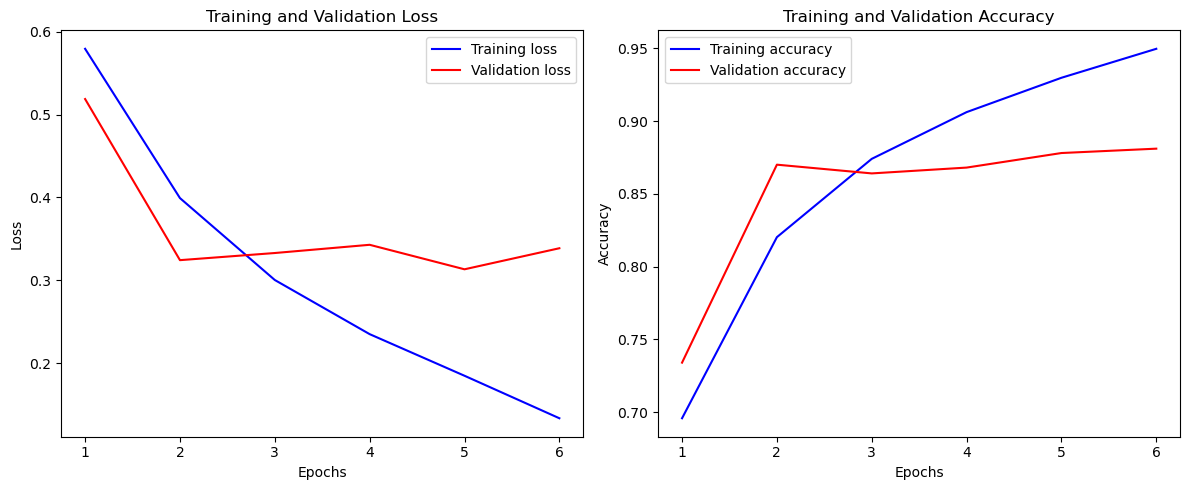

In [200]:
epochs = range(1, EPOCHS + 1)
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


### Testing the Model

In [201]:
# evaluate model
model.eval()

# track loss and accuracy
test_loss = 0.0
correct_predictions = 0
total_predictions = 0

# test
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        
        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)

# calc average test loss and accuracy
test_loss /= len(test_loader.dataset)
test_accuracy = correct_predictions / total_predictions

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


Test Loss: 0.3614
Test Accuracy: 86.95%
